# Initial Experiments w Hierarchical Attention Mechanisms for External Memory

## Data

Model a "language modeling" task of predicting the next "word" in terms of a hidden Markov models.

$$
\begin{align*}
\mathcal{M} &= \{(x^{(t)}, y^{(t)})\}_{t \in [n_m]}\\
x^{(t)} &= (x_1^{(t)}, \ldots, x_l^{(t)})\\
y^{(t)} &= (y_1^{(t)}, \ldots, y_l^{(t)}) = (x_2^{(t)}, \ldots, x_{l+1}^{(t)})\\
\end{align*}
$$

where $x_i^{(t)}$ come from a hidden markov model.
$$
\begin{align*}
z_1^{(t)} &\sim \mu, z_{i+1}^{(t)} \sim P(\cdot | z_i^{(t)})\\
x_i^{(t)} &\sim O(\cdot | z_i^{(t)})
\end{align*}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys;sys.path.append('..')
import utils

## Generate Data

In [2]:
num_loops = 4
loop_length = 6 # for now, fixed length
num_notes = 6 # size of observation space

state_transition_edges = []

for l in range(num_loops):
    for s in range(loop_length):
        state_transition_edges.append((f's{l}{s}', f's{l}{(s+1)%loop_length}'))

    # NOTE: this adds connections between loops
    # for l2 in range(num_loops):
    #     state_transition_edges.append((f's{l}0', f's{l2}0'))

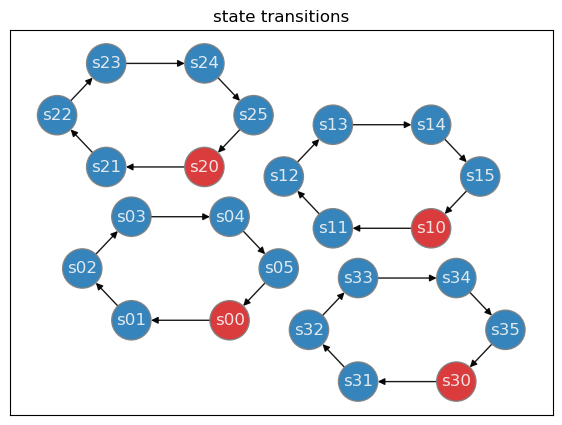

In [3]:
graph = nx.DiGraph(state_transition_edges)

color_map = ['tab:red' if node[-1]=='0' else 'tab:blue' for node in graph.nodes]
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9, "font_color": "whitesmoke"}

fig, ax = plt.subplots(figsize=(7,5))
nx.draw_networkx(graph, with_labels=True, pos=nx.nx_agraph.graphviz_layout(graph, prog='circo'), node_color=color_map, ax=ax, **options)
ax.set_title('state transitions');

In [4]:
states = list(graph.nodes())
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

emissions = [f'o{i}' for i in range(num_notes)]
idx_to_emission = {i: o for i,o in enumerate(emissions)}
emission_to_idx = {o: i for i,o in enumerate(emissions)}

In [5]:
state_transition_matrix = np.array(nx.adjacency_matrix(graph, nodelist=state_to_idx.keys()).todense())
state_transition_matrix = state_transition_matrix / np.sum(state_transition_matrix, axis=0)[:, np.newaxis]

/tmp/ipykernel_416695/216198539.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  state_transition_matrix = np.array(nx.adjacency_matrix(graph, nodelist=state_to_idx.keys()).todense())


In [6]:
emissions_dict = {s: idx_to_emission[np.random.randint(num_notes)] for s in states}
emissions_dict

{'s00': 'o4',
 's01': 'o5',
 's02': 'o5',
 's03': 'o0',
 's04': 'o5',
 's05': 'o2',
 's10': 'o3',
 's11': 'o3',
 's12': 'o3',
 's13': 'o3',
 's14': 'o2',
 's15': 'o1',
 's20': 'o5',
 's21': 'o5',
 's22': 'o3',
 's23': 'o2',
 's24': 'o1',
 's25': 'o4',
 's30': 'o5',
 's31': 'o0',
 's32': 'o1',
 's33': 'o2',
 's34': 'o3',
 's35': 'o2'}

In [7]:
emissions_matrix = np.zeros((len(states), num_notes))
for i, s in enumerate(states):
    emissions_matrix[i, emission_to_idx[emissions_dict[s]]] = 1

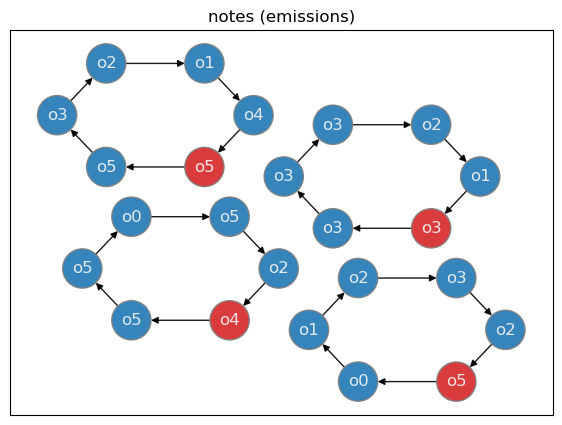

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
nx.draw_networkx(graph, with_labels=True, labels=emissions_dict,
    pos=nx.nx_agraph.graphviz_layout(graph, prog='circo'),
    node_color=color_map, ax=ax, **options)
ax.set_title('notes (emissions)');

In [9]:
def sample_hmm(transition_matrix, emissions_matrix, initial_state, num_steps):
    current_state = initial_state
    states_seq = [current_state]
    emissions_seq = [np.random.choice(emissions, p=emissions_matrix[state_to_idx[current_state], :])]

    for i in range(num_steps-1):
        probabilities = transition_matrix[state_to_idx[current_state], :]
        next_state = np.random.choice(states, p=probabilities)
        states_seq.append(next_state)
        current_state = next_state
        emissions_seq.append(np.random.choice(emissions, p=emissions_matrix[state_to_idx[current_state], :]))
    return states_seq, emissions_seq

In [10]:
mem_seq_len = loop_length + 1
input_seq_len = 2*loop_length

mem_seq_initial_states = [f's{l}0' for l in range(num_loops)]
input_seqs_initial_states = [f's{l}0' for l in range(num_loops)]

train_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, input_seq_len+1) for initial_state in input_seqs_initial_states])
train_state_seqs, train_emissions_seqs = train_seqs[:, 0, :], train_seqs[:, 1, :]
train_seqs_x = train_emissions_seqs[:, :-1]
train_seqs_y = train_emissions_seqs[:, 1:]

mem_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, mem_seq_len + 1) for initial_state in mem_seq_initial_states])
mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=len(train_seqs))
mem_state_seqs, mem_emissions_seqs = mem_seqs[:, :, 0, :], mem_seqs[:, :, 1, :]
mem_seqs_x = mem_emissions_seqs[:, :, :-1]
mem_seqs_y = mem_emissions_seqs[:, :, 1:]


In [11]:
print(f'train_seqs_x.shape: {train_seqs_x.shape}; train_seqs_y.shape: {train_seqs_y.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x.shape: {mem_seqs_x.shape}; mem_seqs_y.shape: {mem_seqs_y.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

train_seqs_x.shape: (4, 12); train_seqs_y.shape: (4, 12)
mem_seqs_x.shape: (4, 4, 7); mem_seqs_y.shape: (4, 4, 7)


In [12]:
mem_state_seqs[0]

array([['s00', 's01', 's02', 's03', 's04', 's05', 's00', 's01'],
       ['s10', 's11', 's12', 's13', 's14', 's15', 's10', 's11'],
       ['s20', 's21', 's22', 's23', 's24', 's25', 's20', 's21'],
       ['s30', 's31', 's32', 's33', 's34', 's35', 's30', 's31']],
      dtype='<U3')

In [13]:
mem_seqs_x[0]

array([['o4', 'o5', 'o5', 'o0', 'o5', 'o2', 'o4'],
       ['o3', 'o3', 'o3', 'o3', 'o2', 'o1', 'o3'],
       ['o5', 'o5', 'o3', 'o2', 'o1', 'o4', 'o5'],
       ['o5', 'o0', 'o1', 'o2', 'o3', 'o2', 'o5']], dtype='<U3')

In [14]:
train_seqs_x

array([['o4', 'o5', 'o5', 'o0', 'o5', 'o2', 'o4', 'o5', 'o5', 'o0', 'o5',
        'o2'],
       ['o3', 'o3', 'o3', 'o3', 'o2', 'o1', 'o3', 'o3', 'o3', 'o3', 'o2',
        'o1'],
       ['o5', 'o5', 'o3', 'o2', 'o1', 'o4', 'o5', 'o5', 'o3', 'o2', 'o1',
        'o4'],
       ['o5', 'o0', 'o1', 'o2', 'o3', 'o2', 'o5', 'o0', 'o1', 'o2', 'o3',
        'o2']], dtype='<U3')

In [15]:
maptoidx = np.vectorize(lambda x: emission_to_idx[x])
train_seqs_x = maptoidx(train_seqs_x)
train_seqs_y = maptoidx(train_seqs_y)
mem_seqs_x = maptoidx(mem_seqs_x)
mem_seqs_y = maptoidx(mem_seqs_y)

In [16]:
mem_seqs_x

array([[[4, 5, 5, 0, 5, 2, 4],
        [3, 3, 3, 3, 2, 1, 3],
        [5, 5, 3, 2, 1, 4, 5],
        [5, 0, 1, 2, 3, 2, 5]],

       [[4, 5, 5, 0, 5, 2, 4],
        [3, 3, 3, 3, 2, 1, 3],
        [5, 5, 3, 2, 1, 4, 5],
        [5, 0, 1, 2, 3, 2, 5]],

       [[4, 5, 5, 0, 5, 2, 4],
        [3, 3, 3, 3, 2, 1, 3],
        [5, 5, 3, 2, 1, 4, 5],
        [5, 0, 1, 2, 3, 2, 5]],

       [[4, 5, 5, 0, 5, 2, 4],
        [3, 3, 3, 3, 2, 1, 3],
        [5, 5, 3, 2, 1, 4, 5],
        [5, 0, 1, 2, 3, 2, 5]]])

## Hierarchical Attention Model

**Attend within each sequence in memory**

For $t \in [n_m]$,
$$\tilde{m}_i^{(t)} \gets \mathrm{CrossAttn}(Q \gets x_i, K \gets x^{(t)}, V \gets y^{(t)})$$

i.e.,

$$
\begin{align*}
\alpha_{ij}^{(t)} &\gets \mathrm{Softmax}([\langle \phi_Q (x_i), \phi_K (x_j^{(t)}) \rangle]_{j \in [[l]]})\\
\tilde{m}_i^{(t)} &\gets \sum_j \alpha_{ij}^{(t)} \phi_V(y_j^{(t)}) = \sum_{j} \alpha_{ij}^{(t)} \phi_V(x_{j+1}^{(t)})
\end{align*}
$$

**Attend over sequences in memory**
$$\alpha_{it} \gets \mathrm{Softmax}([\max_{j} \langle \phi_Q(x_i), \phi_K(x_j^{(t)}) \rangle]_{t \in [n_m]})$$

($\phi_Q, \phi_K$ can be the same as above.)

**Fetch vector from memory**
$$\tilde{m}_i \gets \sum_t \alpha_{it} \tilde{m}_i^{(t)} = \sum_t \sum_j \alpha_{it} \alpha_{ij}^{(t)} \phi_V(x_{j+1}^{(t)})$$

In [17]:
import tensorflow as tf
from tensorflow.keras import layers
from hierarchical_attention import HierarchicalAttention

2023-07-24 15:42:34.612608: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-24 15:42:35.211480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 15:42:36.849205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Define Memory Model

### without self-attention

In [51]:
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.hierarchical_mem_attention = HierarchicalAttention(
            key_dim, value_dim=embedding_dim, 
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')
        self.output_dense = layers.Dense(vocab_size, name='output')

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [52]:
vocab_size = num_notes
embedding_dim = num_notes

memory_model = MemoryModel(vocab_size, embedding_dim=embedding_dim, key_dim=embedding_dim, name='memory_model')
memory_model([train_seqs_x, mem_seqs_x, mem_seqs_y]); # build model

create_opt = lambda: tf.optimizers.Adam(learning_rate=5e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  36        
                                                                 
 mem_attn (HierarchicalAtten  multiple                 108       
 tion)                                                           
                                                                 
 output (Dense)              multiple                  42        
                                                                 
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________


In [53]:
train_ds = tf.data.Dataset.from_tensor_slices(((train_seqs_x, mem_seqs_x, mem_seqs_y), train_seqs_y)).batch(4)

2023-07-24 15:52:55.477680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [4,12]
	 [[{{node Placeholder/_3}}]]


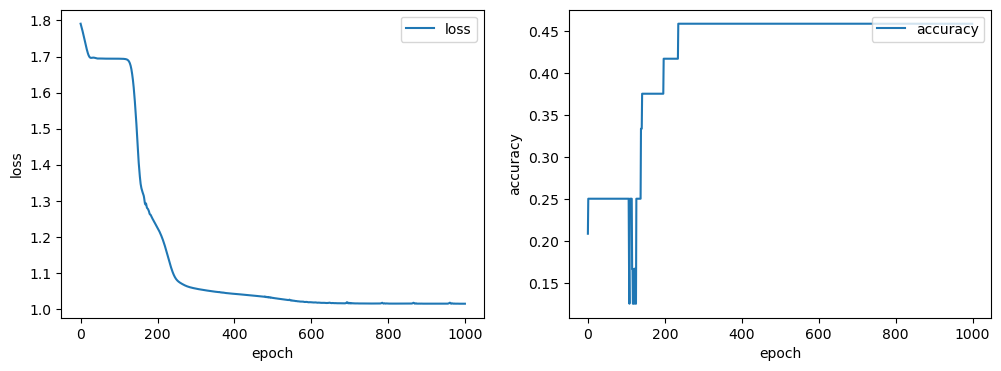

In [54]:
history = memory_model.fit(train_ds, epochs=1000, verbose=0)
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [55]:
memory_model.evaluate(train_ds)

1/1 [==============================] - 0s 220ms/step - loss: 1.0146 - accuracy: 0.4583


[1.0146448612213135, 0.4583333432674408]

1/1 [==============================] - 0s 31ms/step


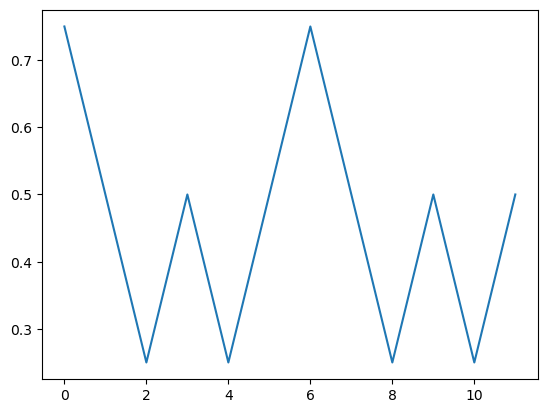

In [65]:
# plot accuracy as a function of position in sequence
preds = memory_model.predict(train_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == train_seqs_y, axis=0)
plt.plot(acc_by_pos)

### with self-attention

In [77]:
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='mem_self_attn')

        # same attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        # self.memory_self_attention_layer = self.self_attention_layer

        self.hierarchical_mem_attention = HierarchicalAttention(
            key_dim, value_dim=embedding_dim,
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')

        self.output_dense = layers.Dense(vocab_size, name='output')

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [78]:
vocab_size = num_notes
embedding_dim = num_notes // 2

memory_model = MemoryModel(vocab_size, embedding_dim=embedding_dim, key_dim=embedding_dim, name='memory_model')
memory_model([train_seqs_x, mem_seqs_x, mem_seqs_y]); # build model

create_opt = lambda: tf.optimizers.Adam(learning_rate=1e-2)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  18        
                                                                 
 self_attn (MultiHeadAttenti  multiple                 48        
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 48        
 ention)                                                         
                                                                 
 mem_attn (HierarchicalAtten  multiple                 27        
 tion)                                                           
                                                                 
 output (Dense)              multiple                  24        
                                                      

In [79]:
train_ds = tf.data.Dataset.from_tensor_slices(((train_seqs_x, mem_seqs_x, mem_seqs_y), train_seqs_y)).batch(4)

2023-07-24 16:04:43.743759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [4,12]
	 [[{{node Placeholder/_3}}]]


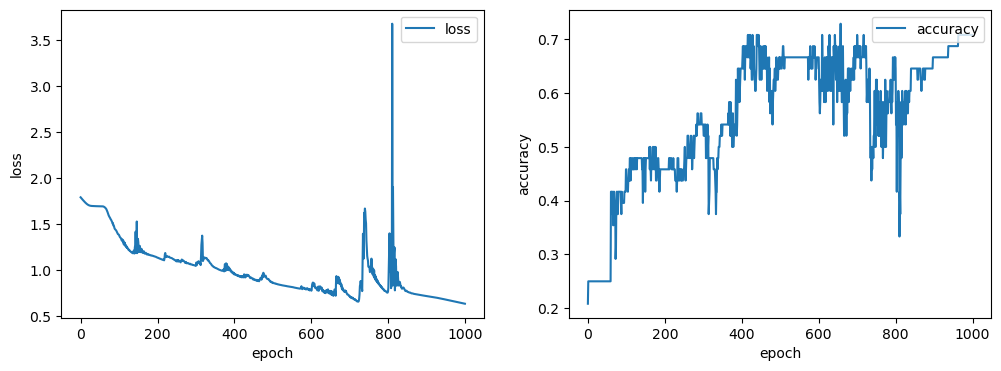

In [80]:
history = memory_model.fit(train_ds, epochs=1000, verbose=0)
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [81]:
memory_model.evaluate(train_ds)

1/1 [==============================] - 0s 356ms/step - loss: 0.6330 - accuracy: 0.7083


[0.633023202419281, 0.7083333134651184]

1/1 [==============================] - 0s 327ms/step


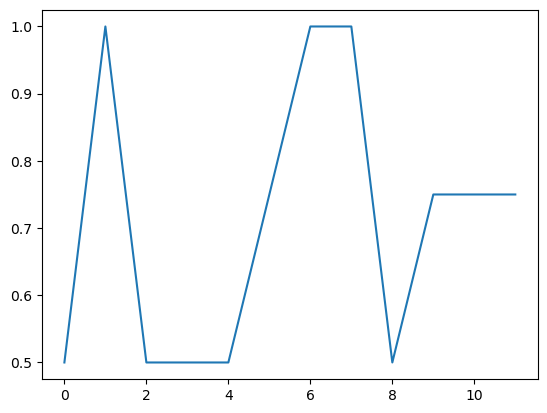

In [82]:
# plot accuracy as a function of position in sequence
preds = memory_model.predict(train_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == train_seqs_y, axis=0)
plt.plot(acc_by_pos)

### Analyze Hierarchical Attention Mechanism

In [28]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_per_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig = plt.figure(figsize=(num_mem_seqs*2,3))
    gs = gridspec.GridSpec(1, num_mem_seqs+1, width_ratios=[0.5]*num_mem_seqs+[0.1])
    axs = [fig.add_subplot(gs[i]) for i in range(num_mem_seqs)]
    cax = fig.add_subplot(gs[-1])
    im = None
    for t, ax in enumerate(axs):
        im = ax.imshow(attn_[t], cmap='gray', vmin=0, vmax=1)
        ax.set_xticks(range(len(mem_seqs_x[t])))
        ax.set_yticks(range(len(train_seqs_x)))
        ax.set_xticklabels(mem_seqs_x[t]);
        ax.set_yticklabels(train_seqs_x);
    fig.colorbar(im, cax=cax)
    axs[0].set_ylabel('input sequence')
    fig.supxlabel('memory sequences', y=0.)
    fig.suptitle('attention within each memory sequence')
    return fig

def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    fig, ax = plt.subplots()
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax);
    return fig


#### Example 1: relevant memory exists in buffer (using the same memory buffer as during training)

In [29]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
sample_mem_seq_x = mem_seqs_x[b:b+1]
sample_mem_seq_y = mem_seqs_y[b:b+1]
print(sample_input[0])
print(sample_mem_seq_x[0])

[3 3 3 3 2 1 3 3 3 3 2 1]
[[4 5 5 0 5 2 4]
 [3 3 3 3 2 1 3]
 [5 5 3 2 1 4 5]
 [5 0 1 2 3 2 5]]


In [30]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[3 3 3 3 3 3 3 3 3 3 3 3]]
[3 3 3 2 1 3 3 3 3 2 1 3]
[[ True  True  True False False  True  True  True  True False False  True]]


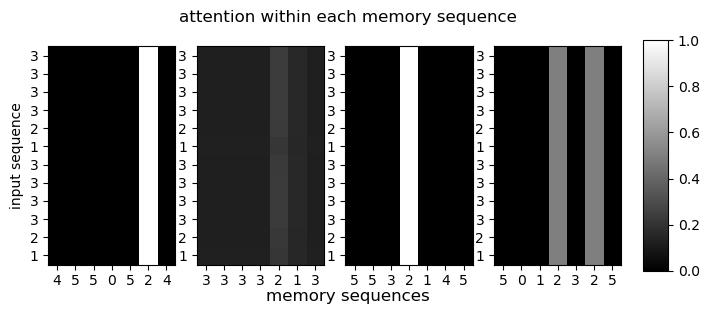

In [31]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

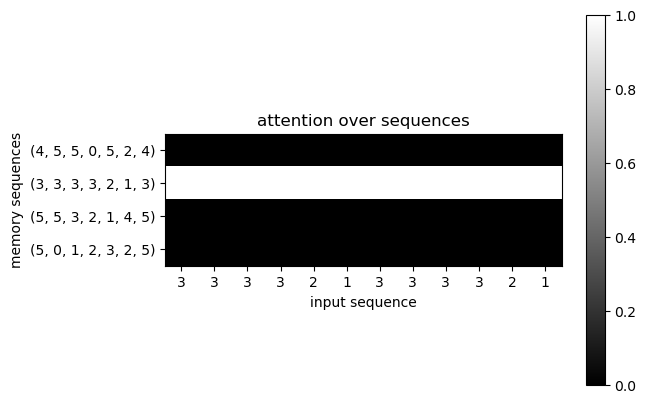

In [32]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

#### Example 2: relevant memory exists in buffer (different memory buffer to one used in training)

In [33]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
sample_mem_seq_x = mem_seqs_x[b:b+1, [0, 1, -1]]
sample_mem_seq_y = mem_seqs_y[b:b+1, [0, 1, -1]]
print(sample_input[0])
print(sample_mem_seq_x[0])

[3 3 3 3 2 1 3 3 3 3 2 1]
[[4 5 5 0 5 2 4]
 [3 3 3 3 2 1 3]
 [5 0 1 2 3 2 5]]


In [34]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[3 3 3 3 3 3 3 3 3 3 3 3]]
[3 3 3 2 1 3 3 3 3 2 1 3]
[[ True  True  True False False  True  True  True  True False False  True]]


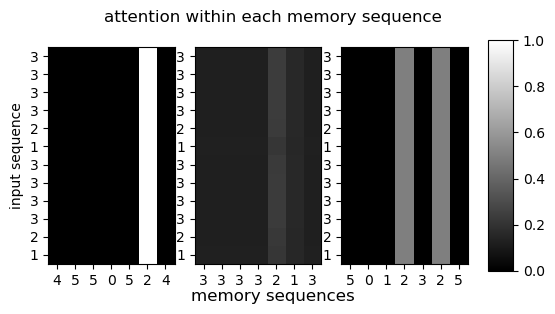

In [35]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

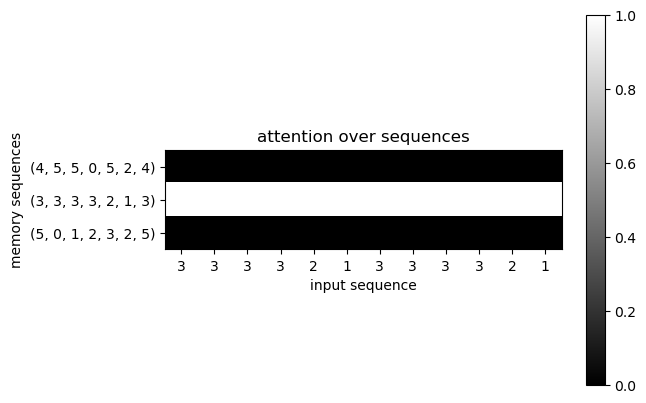

In [36]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

#### Example 3: large memory buffer with many irrelevant sequences

In [37]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
n_reps_ = 5
mem_idxs =  [0] * n_reps_ + [1] + [-2] * n_reps_ + n_reps_ * [-1]
sample_mem_seq_x = mem_seqs_x[b:b+1, mem_idxs]
sample_mem_seq_y = mem_seqs_y[b:b+1, mem_idxs]
print(sample_input[0])
print(sample_mem_seq_x[0])

[3 3 3 3 2 1 3 3 3 3 2 1]
[[4 5 5 0 5 2 4]
 [4 5 5 0 5 2 4]
 [4 5 5 0 5 2 4]
 [4 5 5 0 5 2 4]
 [4 5 5 0 5 2 4]
 [3 3 3 3 2 1 3]
 [5 5 3 2 1 4 5]
 [5 5 3 2 1 4 5]
 [5 5 3 2 1 4 5]
 [5 5 3 2 1 4 5]
 [5 5 3 2 1 4 5]
 [5 0 1 2 3 2 5]
 [5 0 1 2 3 2 5]
 [5 0 1 2 3 2 5]
 [5 0 1 2 3 2 5]
 [5 0 1 2 3 2 5]]


In [38]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[3 3 3 3 3 3 3 3 3 3 3 3]]
[3 3 3 2 1 3 3 3 3 2 1 3]
[[ True  True  True False False  True  True  True  True False False  True]]


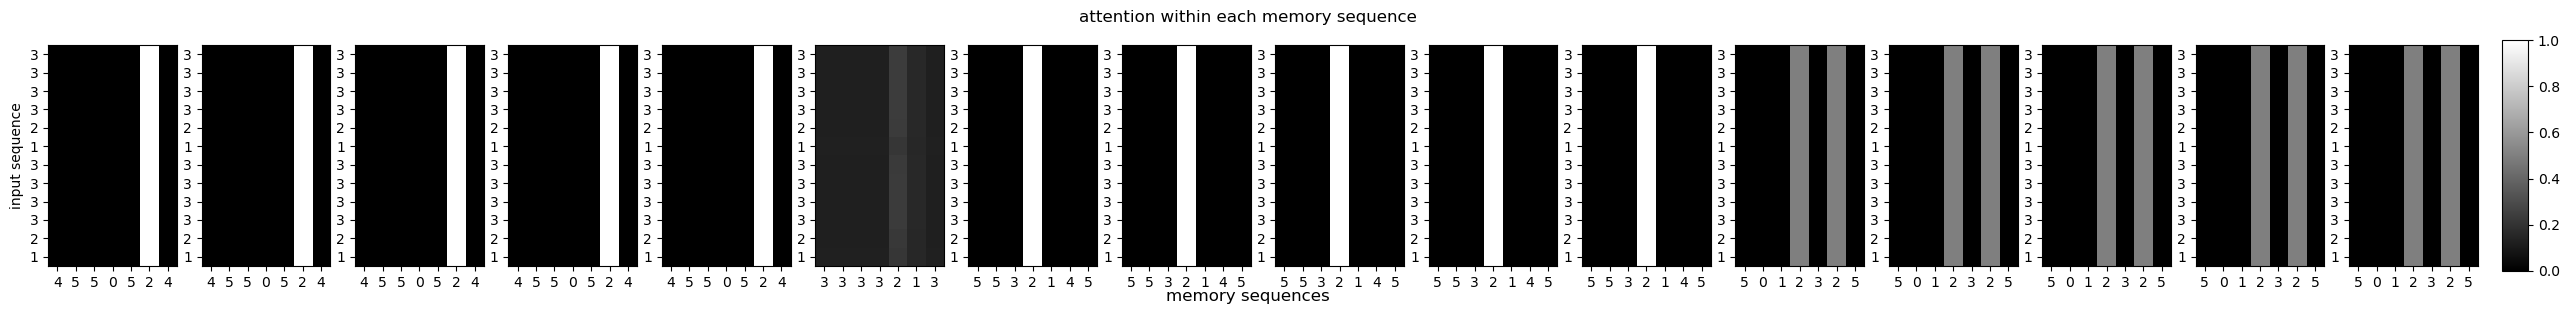

In [39]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

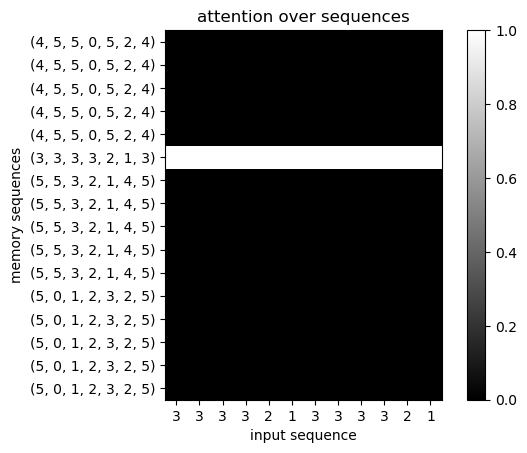

In [40]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

#### Example 4: relevant memory does not exist in buffer; trained w expectation of relevant memory

The model was trained with the sequence $(1, 2, 3, 4, 1, 2)$ and relevant sequences in the memory buffer (e.g. the sequences $(1, 2, 3, 4)$, $(2, 3, 4, 1)$, etc.). When evaluated on the sequence but with a memory buffer containing only irrelevant information, the model fails.

In [41]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
sample_mem_seq_x = mem_seqs_x[b:b+1, [2, 2, 2]]
sample_mem_seq_y = mem_seqs_y[b:b+1, [2, 2, 2]]
print(sample_input[0])
print(sample_mem_seq_x[0])

[3 3 3 3 2 1 3 3 3 3 2 1]
[[5 5 3 2 1 4 5]
 [5 5 3 2 1 4 5]
 [5 5 3 2 1 4 5]]


In [42]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[2 2 2 2 2 2 2 2 2 2 2 2]]
[3 3 3 2 1 3 3 3 3 2 1 3]
[[False False False  True False False False False False  True False False]]


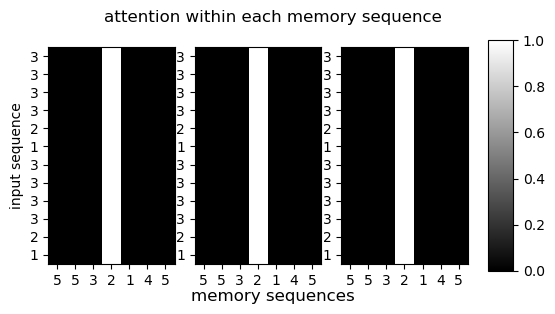

In [43]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

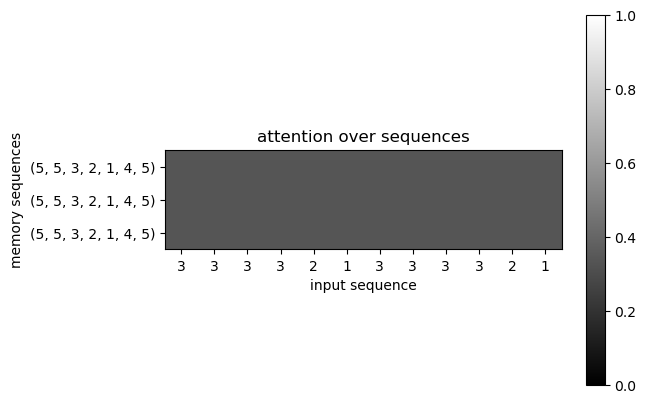

In [44]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);